In [2]:
from numba import njit, prange
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1707)

## Globals

In [3]:
# ----------------------------------- DEBUG ---------------------------------- #
DEBUG = False

# ----------------------------------- TRUTH ---------------------------------- #
FALSE = 0
TRUE = 1
NULL = -1


In [4]:
# ---------------------------------------------------------------------------- #
#                                NODES CREATION                                #
# ---------------------------------------------------------------------------- #

@njit
def randomNodes(shape : tuple[int], scale : int) -> np.ndarray:
    return np.random.random(shape) * scale


@njit
def remove_duplicates(arr):
    unique = []
    for i, row in enumerate(arr):
        for j in range(i+1, len(arr)):
            if np.all(row == arr[j]):
                break
        else:
            unique.append(i)

    unique = np.array(unique)
    return arr[unique]


@njit
def pertubate(nodes : np.ndarray, scale=64) -> np.ndarray:
    nodes_bound = np.max(nodes)
    for i in prange(nodes.shape[0]):
        for j in prange(nodes.shape[1]):
            nodes[i, j] *= scale / nodes_bound
            nodes[i, j] = np.round(nodes[i, j]) * 2 + 1
    return remove_duplicates(nodes)

In [5]:
nodes = randomNodes((10, 2), 4)
pertubate(nodes)

array([[ 35.,  85.],
       [ 79.,  51.],
       [129., 111.],
       [ 19.,  25.],
       [ 49.,  13.],
       [  7., 123.],
       [ 33., 103.],
       [107.,  87.],
       [ 31.,  57.],
       [ 89., 115.]])

## Quadtree

In [6]:
# ---------------------------------------------------------------------------- #
#                                TREE CONSTANTS                                #
# ---------------------------------------------------------------------------- #

# --------------------------------- TREE INFO -------------------------------- #
# tree[0] chứa thông tin về tree
#VD: tree[DATA][MAX_SIZE]
DATA = 0
NEXT_EMPTY = 0
MAX_SIZE = 1
IS_BUILT = 2
TOTAL_VERTEX_COUNT = 3

# -------------------------------- TREE NODES -------------------------------- #
# tree[1:] là các nút
# VD: tree[3][PARENT]
NODES = 1
PARENT = 0
ACTIVE = 1
LEVEL = 2
CHILDREN = 3
AABB = np.array((4, 5, 6))

# ------------------------------ VERTICES INDEX ------------------------------ #
INDEX_COUNT = 0


# ---------------------------------------------------------------------------- #
#                                  TREE UTILS                                  #
# ---------------------------------------------------------------------------- #

@njit
def divide(nodes, node_idx : np.ndarray, aabb):
    startx, starty, box_size = aabb
    box_size //= 2

    left = np.where(nodes[node_idx, 0] < startx + box_size)[0]
    right = np.where(nodes[node_idx, 0] > startx + box_size)[0]
    top = np.where(nodes[node_idx, 1] < starty + box_size)[0]
    bot = np.where(nodes[node_idx, 1] > starty + box_size)[0]

    topleft = node_idx[np.intersect1d(top, left)]
    topright = node_idx[np.intersect1d(top, right)]
    botleft = node_idx[np.intersect1d(bot, left)]
    botright = node_idx[np.intersect1d(bot, right)]

    return (topleft, topright, botleft, botright)


@njit
def divide_aabb(aabb):
    startx, starty, box_size = aabb
    box_size //= 2

    botleft_aabb = np.array((startx, starty, box_size))
    topleft_aabb =  np.array((startx + box_size, starty, box_size))
    botright_aabb = np.array((startx, starty + box_size, box_size))
    topright_aabb =  np.array((startx + box_size, starty + box_size, box_size))

    return (botleft_aabb, topleft_aabb, botright_aabb, topright_aabb)


@njit
def is_inside_aabb(p, aabb, inclusive=True):
    startx, starty, box_size = aabb
    aabb_start = np.array((startx, starty))
    aabb_end = aabb_start + np.array((box_size, box_size))

    if inclusive:
        return np.all(aabb_start <= p) and np.all(p <= aabb_end)
    else:
        return np.all(aabb_start < p) and np.all(p < aabb_end)


@njit
def is_on_edge_aabb(p, aabb):
    return is_inside_aabb(p, aabb, inclusive=True) \
            and not is_inside_aabb(p, aabb, inclusive=False)


@njit
def search_next_power(number : int, power : int) -> int:
    ret = 1
    while ret < number:
        ret *= power
    return ret

@njit
def get_vertex_index(tree_index, tree_vertices_index):
    length = tree_vertices_index[tree_index][0]
    return tree_vertices_index[tree_index][1:length + 1]


@njit
def print_tree(tree):
    print("========== TREE INFO ==========")
    print(f"SIZE: {tree[DATA][NEXT_EMPTY]}")
    print(f"MAX SIZE: {tree[DATA][MAX_SIZE]}")
    print(f"TOTAL VERTEX COUNT: {tree[DATA][TOTAL_VERTEX_COUNT]}")

    print("========== TREE NODES ==========")
    for i, node in enumerate(tree):
        if node[ACTIVE] == NULL:
            break
        print(node)

@njit
def print_vert_idx(tree_vert_idx, tree):
    print("========== VERT IDX INFO ==========")
    print(f"SIZE: {len(tree_vert_idx)}")
    print(f"")
    print("========== VERT IDX ==========")
    for i, node in enumerate(tree):
        if node[ACTIVE] == NULL:
            break
        print(get_vertex_index(i, tree_vert_idx))


In [7]:

@njit
def divide(nodes, node_idx : np.ndarray, aabb):
    startx, starty, box_size = aabb
    box_size //= 2

    left = np.where(nodes[node_idx, 0] < startx + box_size)[0]
    right = np.where(nodes[node_idx, 0] > startx + box_size)[0]
    top = np.where(nodes[node_idx, 1] < starty + box_size)[0]
    bot = np.where(nodes[node_idx, 1] > starty + box_size)[0]

    topleft = node_idx[np.intersect1d(top, left)]
    topright = node_idx[np.intersect1d(top, right)]
    botleft = node_idx[np.intersect1d(bot, left)]
    botright = node_idx[np.intersect1d(bot, right)]

    return (topleft, topright, botleft, botright)



nodes = randomNodes((8, 2), 100)
pertubate(nodes, scale=60)
nodes_idx = np.array((1, 2, 4, 5))

bound = search_next_power(np.max(nodes), 2)
aabb = np.array((0, 0, bound))
print(f"bound: {bound}")
print(divide(nodes, nodes_idx, aabb))
print(nodes[nodes_idx])


bound: 128
(array([4]), array([2]), array([1, 5]), array([], dtype=int32))
[[ 19.  75.]
 [121.  57.]
 [  5.  29.]
 [ 11.  85.]]


In [8]:
tree_idx = 2
tree_vert_idx = np.array((
    (0, 0, 0, 0),
    (1, 1, NULL, NULL),
    (3, 3, 4, 5)
))

get_vertex_index(tree_idx, tree_vert_idx)

array([3, 4, 5])

In [9]:
# ---------------------------------------------------------------------------- #
#                                MAIN FUNCTIONS                                #
# ---------------------------------------------------------------------------- #

@njit
def new_tree(max_size=500, nodes_count=100, dtype=np.int16):
    tree = np.full((max_size, AABB[-1] + 1), NULL, dtype=dtype)
    tree[DATA][NEXT_EMPTY] = 1
    tree[DATA][TOTAL_VERTEX_COUNT] = 0
    tree[DATA][IS_BUILT] = FALSE
    tree[DATA][MAX_SIZE] = max_size

    vertices_idx = np.full((max_size, nodes_count), NULL, dtype=dtype)
    vertices_idx[:, 0] = 0

    return (tree, vertices_idx)


@njit
def add_node_to_tree(tree, tree_vert_idx, parent, vert_idx, aabb):
    if tree[DATA][NEXT_EMPTY] == tree[DATA][MAX_SIZE]:
        temptree = tree
        temp_vert_idx = tree_vert_idx

        tree, tree_vert_idx = new_tree(max_size=temptree[DATA][MAX_SIZE] + 100)
        tree[1:len(temptree)] = temptree[1:len(temptree)]
        tree_vert_idx[1:len(temp_vert_idx)] = temp_vert_idx[1:len(temp_vert_idx)]
        tree[DATA][NEXT_EMPTY] = temptree[DATA][NEXT_EMPTY]

    node = tree[tree[DATA][NEXT_EMPTY]]

    node[PARENT] = parent
    node[ACTIVE] = TRUE
    node[LEVEL] = tree[parent][LEVEL] + 1 if parent != NULL else 0
    node[AABB] = aabb

    node_vert_idx = tree_vert_idx[tree[DATA][NEXT_EMPTY]]
    node_vert_idx[INDEX_COUNT] = len(vert_idx)
    node_vert_idx[1: len(vert_idx)+1] = vert_idx

    tree[DATA][NEXT_EMPTY] += 1
    return (tree, tree_vert_idx)


@njit
def build_tree(tree, vertices, tree_vertices_idx, aabb):
    tree[DATA][IS_BUILT] = TRUE
    tree[DATA][TOTAL_VERTEX_COUNT] = len(vertices)
    add_node_to_tree(tree, tree_vertices_idx, NULL, np.arange(len(vertices)), aabb)

    index = 0
    while index < tree[DATA][NEXT_EMPTY] - 1:
        index += 1

        tree[index][ACTIVE] = TRUE

        if tree_vertices_idx[index][INDEX_COUNT] == 1:
            continue
        if tree_vertices_idx[index][INDEX_COUNT] <= 0:
            continue

        child_idx = tree[DATA][NEXT_EMPTY]
        child_aabb = divide_aabb(tree[index][AABB])
        child_vert_idx = divide(vertices, get_vertex_index(index, tree_vertices_idx), tree[index][AABB])
        tree[index][CHILDREN] = child_idx

        for i in range(4):
            tree, tree_vertices_idx = add_node_to_tree(tree, tree_vertices_idx, index, child_vert_idx[i], child_aabb[i])

    return tree, tree_vertices_idx


@njit
def initialize_tree(vertices, tree_size=100):
    bound = search_next_power(np.max(vertices), 2)
    tree, tree_vert_idx = new_tree(tree_size, dtype=np.int16)
    aabb = np.array((0, 0, bound))

    tree, tree_vert_idx = build_tree(tree, vertices, tree_vert_idx, aabb)
    return tree, tree_vert_idx

In [10]:
vertices = randomNodes((10, 2), 100)
pertubate(vertices)
tree, tree_vert_idx = initialize_tree(vertices, 20)

print_tree(tree)
print_vert_idx(tree_vert_idx, tree)

========== TREE INFO ==========
SIZE: 22
MAX SIZE: 120
TOTAL VERTEX COUNT: 0
========== TREE NODES ==========
[ 22 120   0   0  -1  -1  -1]
[ -1   1   0   2   0   0 256]
[  1   1   1   6   0   0 128]
[  1   1   1  -1 128   0 128]
[  1   1   1  -1   0 128 128]
[  1   1   1  -1 128 128 128]
[ 2  1  2 -1  0  0 64]
[ 2  1  2 10 64  0 64]
[ 2  1  2 14  0 64 64]
[ 2  1  2 18 64 64 64]
[ 7  1  3 -1 64  0 32]
[ 7  1  3 -1 96  0 32]
[ 7  1  3 -1 64 32 32]
[ 7  1  3 -1 96 32 32]
[ 8  1  3 -1  0 64 32]
[ 8  1  3 -1 32 64 32]
[ 8  1  3 -1  0 96 32]
[ 8  1  3 -1 32 96 32]
[ 9  1  3 -1 64 64 32]
[ 9  1  3 -1 96 64 32]
[ 9  1  3 -1 64 96 32]
[ 9  1  3 -1 96 96 32]
========== VERT IDX INFO ==========
SIZE: 120

========== VERT IDX ==========
[]
[0 1 2 3 4 5 6 7 8 9]
[0 2 3 4 5 6 7 8 9]
[]
[1]
[]
[7]
[2 8]
[0 3 9]
[4 5 6]
[8]
[]
[]
[2]
[0]
[3]
[9]
[]
[]
[6]
[4]
[5]


In [11]:


vertices = randomNodes((5, 2), 100)
pertubate(vertices)

v_idx = np.arange(len(vertices))
bound = search_next_power(np.max(vertices), 2)
tree, tree_vert_idx = new_tree(5, dtype=np.int16)
aabb = np.array((0, 0, bound))

tree, tree_vert_idx = add_node_to_tree(tree, tree_vert_idx, parent=NULL, vert_idx=v_idx, aabb=aabb)
tree, tree_vert_idx = add_node_to_tree(tree, tree_vert_idx, parent=1, vert_idx=v_idx, aabb=aabb)
tree, tree_vert_idx = add_node_to_tree(tree, tree_vert_idx, parent=2, vert_idx=v_idx, aabb=aabb)
tree, tree_vert_idx = add_node_to_tree(tree, tree_vert_idx, parent=3, vert_idx=v_idx, aabb=aabb)
tree, tree_vert_idx = add_node_to_tree(tree, tree_vert_idx, parent=4, vert_idx=v_idx, aabb=aabb)
tree, tree_vert_idx = add_node_to_tree(tree, tree_vert_idx, parent=5, vert_idx=v_idx, aabb=aabb)
tree, tree_vert_idx = add_node_to_tree(tree, tree_vert_idx, parent=5, vert_idx=v_idx, aabb=aabb)
tree, tree_vert_idx = add_node_to_tree(tree, tree_vert_idx, parent=5, vert_idx=v_idx, aabb=aabb)


print_tree(tree)
# print_tree(tree_vert_idx)

========== TREE INFO ==========
SIZE: 9
MAX SIZE: 105
TOTAL VERTEX COUNT: 0
========== TREE NODES ==========
[  9 105   0   0  -1  -1  -1]
[ -1   1   0  -1   0   0 256]
[  1   1   1  -1   0   0 256]
[  2   1   2  -1   0   0 256]
[  3   1   3  -1   0   0 256]
[  4   1   4  -1   0   0 256]
[  5   1   5  -1   0   0 256]
[  5   1   5  -1   0   0 256]
[  5   1   5  -1   0   0 256]


## PORTALS

In [12]:
# ---------------------------------------------------------------------------- #
#                                 PORTALIZATION                                #
# ---------------------------------------------------------------------------- #

# ------------------------------- PORTAL UTILS ------------------------------- #

RIGHT = 1
LEFT = 2
DOWN = 3
UP = 4

CORNER_TL = 5
CORNER_TR = 6
CORNER_BL = 7
CORNER_BR = 8

# -------------------------------- PORTAL LIST ------------------------------- #

@njit
def get_square_portal_refs(square_idx, portalref):
    length = portalref[square_idx][0]
    if length == 0:
        return None
    
    return portalref[square_idx][1 : length+1]

# portalref = np.array(((1, 1, NULL, NULL), (3, 2, 3, 4)))
# print(f"PORTALREF: {get_square_portals(0, portalref)}")

@njit
def get_square_portals(square_idx, portalref, portallist):
    portal_mask = get_square_portal_refs(square_idx, portalref)
    square_portals = np.empty((len(portal_mask), 2), dtype=np.float32)
    for i, port_idx in enumerate(portal_mask):
        square_portals[i] = portallist[port_idx]
    return square_portals


@njit
def add_portal(portallist, portal):
    next_idx = np.int32(portallist[DATA][NEXT_EMPTY])
    
    if next_idx == portallist[DATA][MAX_SIZE]:
        new_portallist = np.full((next_idx + 2, int(2)), NULL, dtype=np.float32)
        new_portallist[:next_idx] = portallist
        new_portallist[DATA][MAX_SIZE] = len(new_portallist)
        portallist = new_portallist

    portallist[next_idx] = portal
    portallist[DATA][NEXT_EMPTY] += 1
    return portallist


# portallist = np.array((
#    (5, 5),
#    (1, 2),
#    (3, 4),
#    (5, 6),
#    (7, 8),
# ), dtype=np.float32)
# portallist = add_portal(portallist, np.array((69, 420)))
# portallist = add_portal(portallist, np.array((69, 420)))
# portallist = add_portal(portallist, np.array((69, 420)))
# portallist = add_portal(portallist, np.array((69, 420)))
# portallist = add_portal(portallist, np.array((69, 420)))
# print(portallist)


@njit
def calc_corner_portals(orientation_index, aabb):
    startx, starty, bound = aabb
    pos = np.array((startx, starty))

    if orientation_index == CORNER_TL:
        ret = np.add(pos, np.array((bound, 0)))
        return ret
    
    if orientation_index == CORNER_TR:
        ret = np.add(pos, np.array((bound, bound)))
        return ret
    
    if orientation_index == CORNER_BL:
        return pos
    
    if orientation_index == CORNER_BR:
        ret = np.add(pos, np.array((0, bound)))
        return ret


@njit
def calc_line_portals(orientation_index, aabb, num_portals):
    startx, starty, bound = aabb
    pos = np.array((startx, starty))
    m = num_portals + 1
    ret = None
    increment = np.arange(1, m) * bound / m

    if orientation_index == RIGHT: # right
        pos = np.add(pos, np.array((0, bound)))
        incr = np.vstack((increment, np.zeros(m - 1))).T
        ret = np.add(pos, incr)
        return ret

    if orientation_index == LEFT: # left
        pos = np.add(pos, np.array((0, 0)))
        incr = np.vstack((increment, np.zeros(m - 1))).T
        ret = np.add(pos, incr)
        return ret

    if orientation_index == DOWN: # down
        pos = np.add(pos, np.array((0, 0)))
        incr = np.vstack((np.zeros(m - 1), increment)).T
        ret = np.add(pos, incr)
        return ret
    
    if orientation_index == UP: # up
        pos = np.add(pos, np.array((bound, 0)))
        incr = np.vstack((np.zeros(m - 1), increment)).T
        ret = np.add(pos, incr)
        return ret


# aabb = (0, 0, 8)
# print(calc_line_portals(UP, aabb, 1))
# print(calc_corner_portals(CORNER_TR, aabb))


@njit
def calc_inner_portals(aabb, num_portals):
    inner_portals = np.empty((4*num_portals + 1, 2))

    botleft, _, _, topright = divide_aabb(aabb)
    inner_portals[:num_portals, :] = calc_line_portals(UP, botleft, num_portals)
    inner_portals[num_portals : 2*num_portals, :] = calc_line_portals(RIGHT, botleft, num_portals)
    inner_portals[2*num_portals : 3*num_portals, :] = calc_line_portals(LEFT, topright, num_portals)
    inner_portals[3*num_portals : 4*num_portals, :] = calc_line_portals(DOWN, topright, num_portals)
    inner_portals[4*num_portals] = calc_corner_portals(CORNER_TR, botleft)

    return inner_portals

# ------------------------------- SETUP PORTALS ------------------------------ #

@njit
def build_portallist(tree, num_portals=2, default_size=100):
    portallist = np.full((default_size, 2), NULL, dtype=np.float32)
    portallist[DATA][MAX_SIZE] = default_size
    portallist[DATA][NEXT_EMPTY] = 1

    for index, node in enumerate(tree):
        if node[ACTIVE] == NULL:
            break
        if node[CHILDREN] == NULL:
            continue
        if index == 0:
            continue

        inner_portals = calc_inner_portals(node[AABB], num_portals)
        for portal in inner_portals:
            portallist = add_portal(portallist, portal)

    return portallist


@njit
def build_portalref(tree, portallist):
    portalref = np.full((len(tree), int(portallist[DATA][MAX_SIZE]) + 1), NULL, dtype=np.int16)
    for index, node in enumerate(tree):
        if node[ACTIVE] == NULL:
            break
        if index == 0:
            continue

        aabb = node[AABB]
        portals = np.full(len(portallist) + 1, NULL, dtype=np.int32)
        idx = 1
        for i, port in enumerate(portallist):
            if is_on_edge_aabb(port, aabb):
                portals[idx] = i
                idx += 1
        portals[0] = idx - 1

        if idx == 0:
            continue

        portalref[index] = portals

    return portalref
        

In [13]:
@njit
def add_portal(portallist, portal):
    next_idx = np.int32(portallist[DATA][NEXT_EMPTY])
    
    if next_idx == portallist[DATA][MAX_SIZE]:
        new_portallist = np.full((next_idx + 2, int(2)), NULL, dtype=np.float32)
        new_portallist[:next_idx] = portallist
        new_portallist[DATA][MAX_SIZE] = len(new_portallist)
        portallist = new_portallist

    portallist[next_idx] = portal
    portallist[DATA][NEXT_EMPTY] += 1
    return portallist


@njit
def build_portallist(tree, num_portals=2, default_size=100):
    portallist = np.full((default_size, 2), NULL, dtype=np.float32)
    portallist[DATA][MAX_SIZE] = default_size
    portallist[DATA][NEXT_EMPTY] = 1

    for index, node in enumerate(tree):
        if node[ACTIVE] == NULL:
            break
        if node[CHILDREN] == NULL:
            continue
        if index == 0:
            continue

        inner_portals = calc_inner_portals(node[AABB], num_portals)
        for portal in inner_portals:
            portallist = add_portal(portallist, portal)

    return portallist


@njit
def build_portalref(tree, portallist):
    portalref = np.full((len(tree), int(portallist[DATA][MAX_SIZE]) + 1), NULL, dtype=np.int16)
    for index, node in enumerate(tree):
        if node[ACTIVE] == NULL:
            break
        if index == 0:
            continue

        aabb = node[AABB]
        portals = np.full(len(portallist) + 1, NULL, dtype=np.int32)
        idx = 1
        for i, port in enumerate(portallist):
            if is_on_edge_aabb(port, aabb):
                portals[idx] = i
                idx += 1
        portals[0] = idx - 1

        if idx == 0:
            continue

        portalref[index] = portals
    
    return portalref



vertices = randomNodes((10, 2), 100)
pertubate(vertices)
tree, tree_vert_idx = initialize_tree(vertices, 20)

portallist = build_portallist(tree, num_portals=2)
portalref = build_portalref(tree, portallist)

# print(f"PORTALREF")
# for pref in portalref:
#     print(pref)

# print(f"PORTALLIST: {portallist}")

## Visualize tree

In [19]:
def draw_aabb(aabb, ax):
    startx, starty, bound = aabb
    pos = np.array((startx, starty))
    rect = plt.Rectangle(pos, bound, bound, edgecolor='k', facecolor='none', linewidth=0.7, linestyle="-")
    ax.add_patch(rect)


def draw_vertices(vertices, marker='.', color='b'):
    plt.scatter(vertices[:, 0], vertices[:, 1], marker=marker, c=color) # vẽ portals 


def draw_tree(tree, ax):
    for i, node in enumerate(tree[NODES:]):
        if node[AABB[0]] == NULL:
            break
        draw_aabb(node[AABB], ax)

def draw_portals(portallist, marker="x", color="r"):
    last_idx = portallist[DATA][NEXT_EMPTY]
    valid_portals = portallist[NODES : int(last_idx)]
    plt.scatter(valid_portals[:, 0], valid_portals[:, 1], marker=marker, color=color, alpha=0.5)

def draw_square_portals(square_idx, portallist, portalref, marker="x", color="r"):
    portals = get_square_portals(square_idx, portalref, portallist)
    plt.scatter(portals[:, 0], portals[:, 1], marker=marker, color=color)

In [15]:
vertices = randomNodes((50, 2), 100)

In [16]:
import time

i_iter = 10
j_iter = 100
t_sum = 0
for i in range(i_iter):
    t1 = time.time_ns()
    for j in range(j_iter):
        shift = np.random.rand(2) * np.max(vertices) // 2
        shift_vertices = vertices.copy()
        shift_vertices += shift
        pertubate(shift_vertices)

        ti, t_idx_i = initialize_tree(shift_vertices, 200)
    t_sum += (time.time_ns() - t1) / j_iter

print(t_sum / 10)

972525.1


In [26]:
vertices = randomNodes((20, 2), 100)

shift = (np.random.rand(2) * np.max(vertices) // 2) * 2
shift_vertices = vertices.copy()
pertubate(shift_vertices)
shift_vertices += shift
print(f"shift: {shift}")

tree, tree_vert_idx = initialize_tree(shift_vertices, 300)
portallist = build_portallist(tree, num_portals=3)
portalref = build_portalref(tree, portallist)


shift: [28. 22.]


node: [ 7  1  3 -1 64  0 32]
portal refs: [14 15 40 41 42 43 44 45 52]
portals: [[64. 16.]
 [64. 32.]
 [96.  8.]
 [96. 16.]
 [96. 24.]
 [72. 32.]
 [80. 32.]
 [88. 32.]
 [96. 32.]]


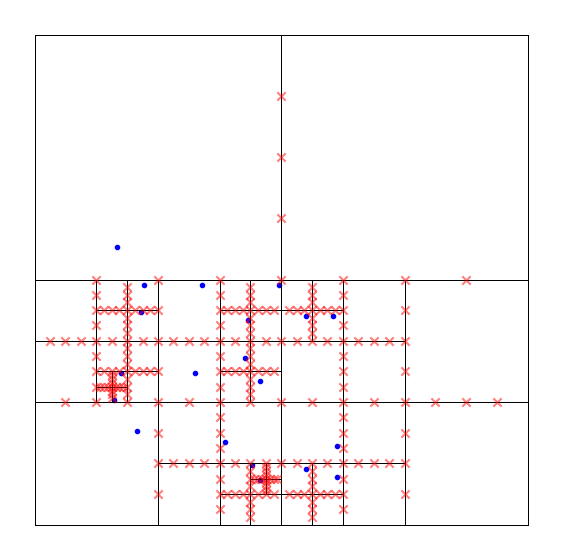

In [28]:
square_idx = 14

fig, ax = plt.subplots(figsize=(7,7))
draw_vertices(shift_vertices)
draw_tree(tree, ax)
draw_portals(portallist)
# draw_square_portals(square_idx, portallist, portalref)

print(f"node: {tree[square_idx]}")
print(f"portal refs: {get_square_portal_refs(square_idx, portalref)}")
print(f"portals: {get_square_portals(square_idx, portalref, portallist)}")

plt.axis('off')
plt.show()

## Dynamic Programming

In [39]:
# ------------------------------ DP TABLE INDEX ------------------------------ #
IS_BASE_CASE = 0
SUBPROBLEM = np.array((1, 2, 3, 4))
CASE_IDX = 1

# --------------------------------- DP UTILS --------------------------------- #

@njit
def get_subset(index, num_elements):
    index *= 3
    subset = np.zeros(num_elements, dtype=np.bool_)
    for j in range(num_elements):
        if (index >> j) & 1:
            subset[j] = True
    return subset

@njit
def count_subset(num_elements):
    count = 0
    while not np.all(get_subset(count, num_elements)):
       count += 1
    return count


# @njit
# def generate_subproblem_indices(num_portals, num_intersections):
#     subproblem_configs = np.full((2** num_portals, 4*num_portals + 4), False, dtype=np.bool_)
#     for i in range(num_portals):

def generate_subproblem_configs(num_portals, num_intersections):
    configs = []
    portal_count = 4*num_portals + 4
    for i in range(2 ** num_portals):


# def get_subproblem_portal_config(subproblem_idx)


# --------------------------------- DP TABLE --------------------------------- #


array([ True,  True, False, False])

In [47]:
@njit
def argintersect2D(set1, set2):
    mask1 = np.array([False for i in set1], dtype=np.bool_)
    mask2 = np.array([False for i in set2], dtype=np.bool_)

    for i, elem in enumerate(set1):
        for j in range(len(set2)):
            if (elem == set2[j]).all():
                mask1[i] = True
                mask2[j] = True

    idx1 = np.argwhere(mask1 == True).T[0]
    idx2 = np.argwhere(mask2 == True).T[0]
    return (idx1, idx2)



array1 = np.array([[1, 2], [3, 4]])
array2 = np.array([[3, 4], [5, 6], [1, 2]])
print(argintersect2D(array1, array2))

port1 = get_square_portal_refs(2, portalref)
port2 = get_square_portal_refs(3, portalref)
print(np.intersect1d(port1, port2))


(array([0, 1], dtype=int64), array([0, 2], dtype=int64))
[ 1  2  3  4  5  6 25]


In [20]:
@njit
def calc_base_portals(num_portals):
    base_aabb = np.array((0, 0, num_portals + 1))
    base_portals = np.empty((4*num_portals + 4, 2))

    base_portals[0] = calc_corner_portals(CORNER_BL, base_aabb)
    base_portals[1 : num_portals+1] = calc_line_portals(DOWN, base_aabb, num_portals)
    base_portals[num_portals + 1] = calc_corner_portals(CORNER_BR, base_aabb)
    base_portals[num_portals + 2 : 2*num_portals + 2] = calc_line_portals(RIGHT, base_aabb, num_portals)
    base_portals[2*num_portals + 2] = calc_corner_portals(CORNER_TR, base_aabb)
    base_portals[2*num_portals + 3 : 3*num_portals + 3] = calc_line_portals(UP, base_aabb, num_portals)
    base_portals[3*num_portals + 3] = calc_corner_portals(CORNER_TL, base_aabb)
    base_portals[3*num_portals + 4 : 4*num_portals + 4] = calc_line_portals(LEFT, base_aabb, num_portals)

    return base_portals
    

calc_base_portals(5)


def get_subproblem_index(portals):
    

array([[0., 0.],
       [0., 1.],
       [0., 2.],
       [0., 3.],
       [0., 4.],
       [0., 5.],
       [0., 6.],
       [1., 6.],
       [2., 6.],
       [3., 6.],
       [4., 6.],
       [5., 6.],
       [6., 6.],
       [6., 1.],
       [6., 2.],
       [6., 3.],
       [6., 4.],
       [6., 5.],
       [6., 0.],
       [1., 0.],
       [2., 0.],
       [3., 0.],
       [4., 0.],
       [5., 0.]])

In [2]:
from numba import njit

@njit
def bini(i):
    return bin(i)

bini(3)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'bin':[0m [1m[1mCannot determine Numba type of <class 'builtin_function_or_method'>[0m
[1m
File "..\..\..\..\..\AppData\Local\Temp\ipykernel_22104\2443661789.py", line 5:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m

: 

In [58]:
import numpy as np
from numba import njit

@njit
def number_to_binary_bool_array_njit(number):
    # Step 1: Manually calculate the binary representation
    binary_digits = []
    while number > 0:
        remainder = number % 2
        binary_digits.append(remainder)
        number = number // 2
    
    # Step 2: Reverse the binary digits
    # binary_digits = binary_digits[::-1]
    
    # Step 3: Convert to boolean array (1 is True, 0 is False)
    bool_array = np.array(binary_digits, dtype=np.bool_)
    
    return bool_array

# Example usage:
num = 4  # Binary: 1101
binary_bool_array = number_to_binary_bool_array_njit(num)
print(binary_bool_array)


[False False  True]
